# Mahindra First Choice Services (MFCS) Project

Mahindra First Choice Services (MFCS) is a company of Mahindra Group and is India’s leading chain of multi-brand car workshops with over 335+ workshops present in 267+ towns & 24 states. It has serviced over 10,50,000 cars. The company aims to establish countrywide network of over 400 workshops by March 2018.
Mahindra would now like to leverage the data that they have and address the key issues they have. Read along to know how you can help them improve their business.
The dataset consist of three aspects:

1. **Customer data**: where the details of the customer like the car owned, state and place of residence, order type, etc are present. Data dimension is of ​534000 Customer entries
2. **Invoice data**: ​where information related to customer visits and transactions are recorded, whether a customer as insurance claims, ​bifurcation of the amount paid, for what type of service did the customer came for, etc...
3. **Material Inventory**: where information related to what kind of service did the customer took and what kind of material was used to service, Labor information and the cost for the service, Plant and plant name where the customer took the service.

**Problem Statement-1**: Identifying the ownership pattern of cars throughout the country. This also captures the problem wherein information regarding the spending patterns can be identified.

    - Mahindra First Choice Services will be benefited in multiple ways. Knowing the ownership pattern targeted marketing campaigns could be carried out. Knowing the spending patterns services could be suited to the particular spending pattern.

**Problem Statement-2**: Identify the various types of orders.

    - This could potentially give information about how Mahindra First Choice needs to be prepared to tackle various seasonal cases.


**Problem Statement-3**: Revenue Analysis.

    - This would help determine which streams of revenue are beneficial and improve marketing strategies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import seaborn as sns
import pgeocode

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

In [2]:
ls

LICENSE      README.md    __pycache__/ assets/      data/        main.ipynb


In [3]:
ls data/

Customer_Data.xlsx                   Mahindra Field Information (1).xlsx
Final_invoice.csv                    Plant Master.xlsx
JTD.csv


In [4]:
def mem_usage(data):
        if isinstance(data,pd.DataFrame):
            usage_b = data.memory_usage(deep=True).sum()
        else: # we assume if not a df it's a series
            usage_b = data.memory_usage(deep=True)
        usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
        return "{:03.2f} MB".format(usage_mb)
    
    
def mem_optimizer(data):
    opt_data = data.copy()
    print('Original memory of the dataframe: ', mem_usage(data))
    # for integer values
    gl_int = data.select_dtypes(include=['int'])
    converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')
    # for float values
    gl_float = data.select_dtypes(include=['float'])
    converted_float = gl_float.apply(pd.to_numeric,downcast='float')
    # for object values
    gl_obj = data.select_dtypes(include=['object']).copy()
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5: # convert columns with less than 50% unique values
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    # store the optimized values
    opt_data[converted_int.columns] = converted_int
    opt_data[converted_float.columns] = converted_float
    opt_data[converted_obj.columns] = converted_obj
    print('Final optimized memory of the dataframe: ', mem_usage(opt_data))
    
    return opt_data

def write_percent(ax, total_size):
    '''Traverse the figure object and display the ratio at the top of the bar graph.'''
    for patch in ax.patches:
        height = patch.get_height() # Figure height (number of data)
        width = patch.get_width() # Figure width
        left_coord = patch.get_x() # The x-axis position on the left edge of the figure
        percent = height/total_size*100 # percent
        
        # Type text in the (x, y) coordinates
        ax.text(x=left_coord + width/2.0, # x-axis position
                y=height + total_size*0.001, # y-axis position
                s=f'{percent:1.1f}%', # Text
                ha='center') # in the middle
        
def display_all(df):
    with pd.option_context('display.max_rows', 5000, 'display.max_columns', 1000):
        display(df)

In [5]:
cust_df = pd.read_excel('data/Customer_Data.xlsx')
invoice_df = pd.read_csv('data/Final_invoice.csv')
jtd_df = pd.read_csv('data/JTD.csv')
plants_df = pd.read_excel('data/Plant Master.xlsx')
field_info = pd.read_excel('data/Mahindra Field Information (1).xlsx')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (9,10,14,15,21,41,51) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
df_list = [cust_df, invoice_df, jtd_df, plants_df, field_info]
for i in range(len(df_list)):
    df_list[i] = mem_optimizer(df_list[i])
    print()

Original memory of the dataframe:  109.07 MB
Final optimized memory of the dataframe:  53.26 MB

Original memory of the dataframe:  799.14 MB
Final optimized memory of the dataframe:  168.58 MB

Original memory of the dataframe:  1870.68 MB
Final optimized memory of the dataframe:  194.15 MB

Original memory of the dataframe:  0.30 MB
Final optimized memory of the dataframe:  0.21 MB

Original memory of the dataframe:  0.02 MB
Final optimized memory of the dataframe:  0.01 MB



Starting out with the project, a quick glance at the data will reveal that there are a number of columns that aren't relevant to the problem statement.

In [7]:
display_all(invoice_df.head(3))
print(f'Shape of the raw DataFrame: {invoice_df.shape}')

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total Amt Wtd Tax.,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2
2,2,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE[W],NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NaN,NO,0.0,AP09AX0582,0.0,0.0,0.0,0.0,NaN,0.0,IMRAN,233.14,0.0,0.0,0.0,0.0,233.14,BC01SA2


Shape of the raw DataFrame: (492314, 59)


Such columns can be dropped for the time being. We can add them later if needed.

In [8]:
invoice_cleaned = invoice_df.drop(['Area / Locality', 'Unnamed: 0', 'Cash /Cashless Type', 'Invoice Date', 'Invoice Time', 'JobCard Date', 'JobCard Time','Amt Rcvd From Custom' ,
                     'Amt Rcvd From Ins Co', 'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)', 'IGST(12%)', 
                     'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)',
                     'SGST/UGST(9%)', 'Total CGST', 'Total GST', 'Total IGST', 'Total SGST/UGST', 'Claim No.', 
                     'Expiry Date', 'Gate Pass Date', 'Gate Pass Time', 'Insurance Company', 
                     'Plant', 'Plant Name1', 'Policy no.', 'Print Status', 'Recovrbl Exp', 'Service Advisor Name', 
                     'TDS amount', 'Total Value', 'ODN No.'], axis=1)

In [9]:
display_all(invoice_cleaned.head(3))
print(f'Shape of the cleaned DataFrame: {invoice_cleaned.shape}')

,CITY,Cust Type,Customer No.,District,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Regn No,Technician Name,Total Amt Wtd Tax.,User ID
0,Thane,Retail,67849,Maharashtra,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,0.0,2348.75,400601,KA19MA1291,RUPESH,4051.95,BC01FS1
1,THNAE,Retail,84419,Maharashtra,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.0,0.00,400603,MH43R3046,PRASHANT,1001.29,BC01SA2
2,THANE[W],Retail,81055,Maharashtra,7005200004,173889,33985,180.19,MARUTI SUZUKI,0.00,ZEN,0.00,Running Repairs,0.0,52.95,400607,AP09AX0582,IMRAN,233.14,BC01SA2


Shape of the cleaned DataFrame: (492314, 20)


In [10]:
invoice_cleaned.columns = ['_'.join(i.split()).lower() for i in invoice_cleaned.columns]

In order to start with geolocation based analysis (Problem Statement - 1), the district column is necessary. However it requires cleaning because the values are inconsistent or erroneous at times. 

In [11]:
invoice_cleaned.district.nunique()

36

In [12]:
nomi = pgeocode.Nominatim('IN')

invoice_cleaned["city"]=nomi.query_postal_code(np.array(invoice_df["Pin code"].astype(str))).county_name
invoice_cleaned["district_imptd"]=nomi.query_postal_code(np.array(invoice_df["Pin code"].astype(str))).state_name
invoice_cleaned["locality"]=nomi.query_postal_code(np.array(invoice_df["Pin code"].astype(str))).place_name

In [13]:
district = invoice_cleaned.loc[invoice_cleaned['district_imptd'].isnull(), 'district']
invoice_cleaned.loc[invoice_cleaned['district_imptd'].isnull(), 'district_imptd'] = district

In [14]:
invoice_cleaned.drop('district', axis=1, inplace=True)
invoice_cleaned.rename(columns={'district_imptd': 'district'}, inplace=True)

In [15]:
invoice_cleaned.loc[invoice_cleaned.district == 'Jammu and Kashmir', 'district'] = 'Jammu & Kashmir'
invoice_cleaned.loc[invoice_cleaned.district == 'Daman and Diu', 'district'] = 'Dadra and Nagar Haveli and Daman and Diu'
invoice_cleaned.loc[invoice_cleaned.district == 'Dadra and Nagar Hav.', 'district'] = 'Dadra and Nagar Haveli and Daman and Diu'
invoice_cleaned.loc[invoice_cleaned.district == 'Chattisgarh', 'district'] = 'Chhattisgarh'
invoice_cleaned.loc[invoice_cleaned.district == 'Pondicherry', 'district'] = 'Puducherry'


As a result, the district column is re-created using the pincodes provided so as to rectify the errors. **pgeocode** library is used to extract this information. However, some manual effort is still required to correct the remaining inconsistencies.

In [16]:
invoice_cleaned.district.nunique()

29

Now that these districts have been set, there are a few districts with relatively low frequencies. These districts have been reduced to a single value called `others`.

In [17]:
other_states = invoice_cleaned.district.value_counts().index[11:]
other_states

Index(['Kerala', 'Delhi', 'Chandigarh', 'Bihar', 'Himachal Pradesh',
       'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Dadra and Nagar Haveli and Daman and Diu', 'Jharkhand', 'Assam', 'Goa',
       'Arunachal Pradesh', 'Jammu & Kashmir', 'Lakshadweep', 'Nagaland'],
      dtype='object')

In [18]:
invoice_cleaned['district_grp'] = np.where(invoice_cleaned.district.isin(other_states), 'Others', invoice_cleaned.district)

Also, there are 28 unique values for `make` in the dataset.

In [19]:
invoice_cleaned.make.nunique()

28

These values can be clubbed into a 4 distinct categories:

        - Hatchback
        - SUV
        - Utility
        - Luxury
        - Sedan

In [20]:
SUV = ['ENDEAVOUR','DUSTER','INNOVA','INDIGO MARINA', 'FORTUNER', 'TAVERA', 'XYLO', 'SCORPIO CRDE', 'SCORPIO NEF', 
       'SAFARI', 'XUV 500', 'SUMO','QUALIS','BOLERO','ADVENTURE', 'CR-V', 'CAPTIVA','QUANTO','SSANYONG KORANDO','ERTIGA'
      'ARIA','SUMO GRANDE', 'FORCE ONE', 'X-TRAIL', 'COMMANDER', 'GYPSY 1000', 'ROOMSTER', 'TRAX', 'THAR', 'TAVERA NEO', 
       'RHINO RX', 'ARMADA', 'GYPSY 1300', 'YETI', 'MARSHAL', 'SIERRA', 'TERRACAN', 'PAJERO','MONTERO', 
      'ROVER', 'LAND ROVER DISCOVERY', 'MAHINDRA MM', 'SSANYONG REXTON', 'CLASSIC','KOLEOS', 'SANTA FE',
       'GRAND VITARA', 'FORESTER', 'RIO','ECOSPORT','TERRANO', 'MOBILIO', 'ENJOY', 'OUTLANDER', 'TOUAREG',
       'LAND CRUISER PRADO', 'LODGY', 'TUCSON', 'LAND ROVER RANGE ROVER', 'LAND ROVER FREELANDER', 'CRETA', 
       'KWID', 'KUV100', 'BREZZA', 'BRV', 'TUV300', 'EVALIA','ECO SPORT','TRAILBLAZER']

utility = ['EECO', 'MAXX', 'OMNI','MAGIC','VERSA', 'BOLERO PIK UP','MAHINDRA CNG','MAHINDRA PIK UP',
       'WINGER', 'VENTURE','207','XENON XT','ACE','MAXXIMO','GENIO', 'SUPRO', 'TREKKER', 'PUSHPAK']

lux = list(invoice_df[invoice_df['Make'].isin(['AUDI', 'BMW', 'PORCHE', 'VOLVO', 'MERCEDES BENZ', 'JEEP' ,'MORRIS', 'SAN MOTORS'])]['Model'])
luxury = lux+['JAGUAR XF', 'JAGUAR XJ', 'JAGUAR XL','LIMOUSINE']


sedan=['CITY','SWIFT DZIRE','FIESTA','RAPID','LOGAN P','ACCENT','VERNA','LOGAN D','CIVIC','SX4','LAURA',
       'OPTRA','LINEA','INDIGO MANZA','COROLLA','VENTO','AMAZE','SUPER SUNNY','CHEVROLET CRUZE','OCTAVIA',
       'OPEL','FUSION','SUPERB','OPEL CORSA','LANCER','SAIL','JETTA','COROLLA ALTIS',
       'ACCORD','ESTEEM 1000','MATIZ','SONATA','OPTRA MAGNUM','TEANA','XCENT','ELANTRA',
       'CAMRY','CONTESSA','OPEL ASTRA','PASSAT','AMBASSADOR','FOCUS','FLUENCE','SONATA V-6',
       'CEDIA','KIZASHI','PETRA','SIENA','TL','MONDEO','SWIFT D,ZIRE','ZEST','CIAZ','SCALA','PADMINI','CIELO',
       'BOLT','VECTRA','AMEO','AVIGO','NEXIA']

invoice_cleaned['model_type'] = np.where(invoice_cleaned['model'].isin(SUV), 'SUV', np.where(invoice_cleaned['model'].isin(sedan), 'Sedan', np.where(invoice_cleaned['model'].isin(luxury), 'Luxury', np.where(invoice_cleaned['model'].isin(utility), 'Utility', 'Hatchback'))))


invoice_cleaned['model_type'].value_counts()

Hatchback    281333
SUV           98766
Sedan         95397
Utility       14478
Luxury         2340
Name: model_type, dtype: int64

With this we are ready to approach our first problem statement!

## Ownership patterns

In [21]:
op_retail = invoice_cleaned[invoice_cleaned.cust_type == 'Retail']
sb_df = op_retail.groupby(['district_grp', 'model_type', 'make'])[['customer_no.']].nunique()
sb_df = sb_df['customer_no.'].groupby(['district_grp', 'model_type'], group_keys=False).nlargest(3).reset_index()

sb_df['country'] = 'India'

fig = px.sunburst(sb_df,
                  path=["country", "district_grp", "model_type", "make"],
                  values='customer_no.',
                  width=750, height=750,
                  title="Sunburst Chart of Cars in Indian States",
)
fig.update_traces(
    hovertemplate= "%{label} <br>Count: %{value} </br>"
)

fig.show()

fig.write_html("assets/cars-states-fig1.html")

The plot above aids us in comprehending our customer base. Before charting, the data was filtered by the `cust type` column to only include retail customers, as the ownership pattern can only be identified when the consumer owns the automobile.

The majority of our consumers come from the states of Maharashtra and Tamil Nadu. This is most likely attributable to the fact that these states have more service plants. Hatchbacks are the most popular category in the country, followed by SUVs. Maruti Suzuki is the most popular car brand among our consumers. A luxury automobile is owned only by a small percentage of clients.

The above observations suggest that the majority of our customers are from the middle class.

## Order types and Service Times

We'll need some feature engineering before moving on to the next problem statement. The difference (in hours) between the columns `JobCardDateTime` - signifies the time when the automobile arrived for service, and `InvoiceDateTime` - shows the time when the invoice was created, is used to create a new column called `service time hrs`.

This new feature indicates the amount of time, in hours, taken to perform the service.

In [22]:
invoice_cleaned['InvoiceDateTime'] = pd.to_datetime(invoice_df['Invoice Date']+' '+invoice_df['Invoice Time'])
invoice_cleaned['JobCardDateTime'] = pd.to_datetime(invoice_df['JobCard Date']+' '+invoice_df['JobCard Time'])

In [23]:
invoice_cleaned['service_time'] = invoice_cleaned['InvoiceDateTime'] - invoice_cleaned['JobCardDateTime']
invoice_cleaned["service_time_hrs"]=invoice_cleaned["service_time"]/np.timedelta64(1, 'h')

To determine the frequency and average service time, the above figure was created by grouping on the `order type` column and getting the average and count of the `service_time_hrs` column. To decrease the impact of outliers, the median was utilised to calculate the average.

In [24]:
srv_time = invoice_cleaned.groupby('order_type')['service_time_hrs'].agg(['count', 'median'])
srv_time.reset_index(inplace=True)
srv_time = srv_time.iloc[:-2]
srv_time['median'] = np.round(srv_time['median'], 2)


fig = px.bar(srv_time, 
             x='count', 
             y='order_type', 
             color='median', 
             orientation='h', 
             template='simple_white',
             labels={"count": "Count",  "median": "Median Hours", "order_type": "Order Type"},
             title='Frequency of Type of Orders Received Colored by Average Service Time'
            )
fig.show()

fig.write_html("assets/orders-service-time-fig2.html")

After the above-mentioned aggregations, the plot reveals that a substantial percentage of our customer population (about 80%) visits our plant for running repairs and paid services. Running repairs often take roughly 6 hours to complete, whereas paid services typically take a day to complete. Accidental repairs take a long time to complete, which might be correlated to the magnitude of the damage or the availability of parts.

We can probably reduce the service times by knowing the nature of the visit beforehand and stocking up on the parts accordingly.

Let's analyze whether location plays a role in the time taken to complete a service.

In [25]:
car_service = (invoice_cleaned
               .groupby(['make', 'district_grp'])['service_time_hrs']
               .median()
               .unstack()
               .fillna(0.0)
)


In [26]:
normalized_df = car_service.div(car_service.sum(axis=1), axis=0)

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_9184/872897866.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_9184/872897866.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



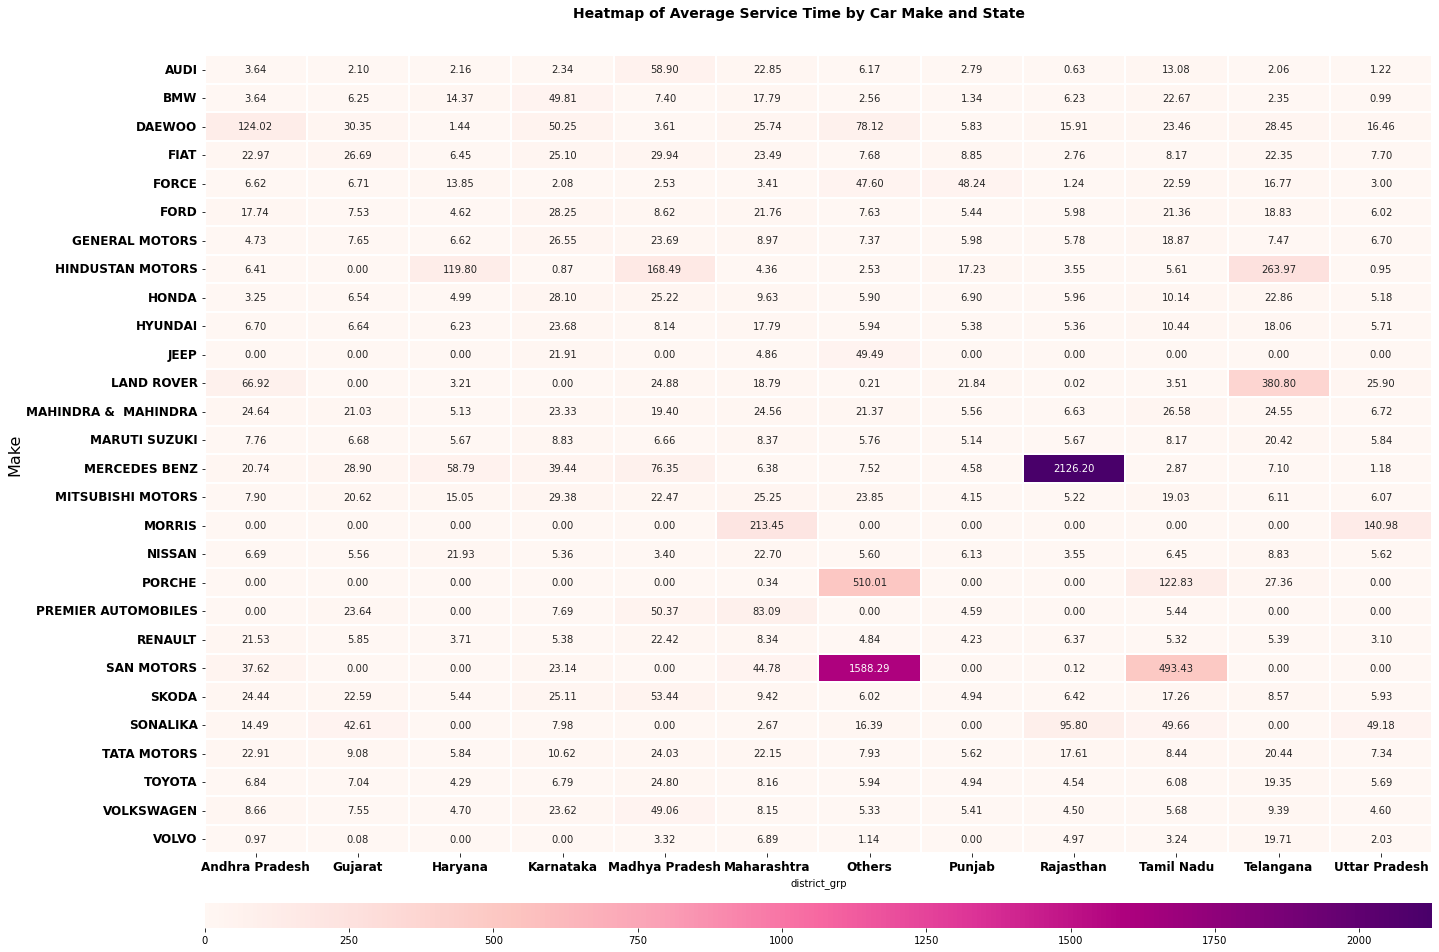

In [27]:
fig4, ax = plt.subplots(figsize=(22, 17))
fig4.subplots_adjust(top=.94)
plt.suptitle('Heatmap of Average Service Time by Car Make and State', 
             fontsize=14, fontweight='bold')

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, weight='bold')

cbar_kws = {'orientation':"horizontal", 'pad':0.05, 'aspect':50}

sns.heatmap(car_service, 
            annot=True, 
            fmt='.2f', 
            linewidths=.3, 
            ax=ax, 
            cmap='RdPu', 
            cbar_kws=cbar_kws
);
ax.set_ylabel('Make', fontsize=16)

plt.savefig('assets/service-time-make-state-fig3.jpeg', bbox_inches='tight')

 Considering Maruti Suzuki, the most frequent car across states, we observe that the average service time in Telangana is relatively high. The second most popular brand - Mahindra & Mahindra, usually takes a day on average to complete the service.

It would be interesting to check if there is a seasonal trend in the number of incoming customers.

In [28]:
season = invoice_cleaned.copy()
season['arrive_day'] = season['JobCardDateTime'].dt.day_name()
season['arrive_month'] = season['JobCardDateTime'].dt.month_name()
season['arrive_hr'] = season['JobCardDateTime'].dt.hour

In [29]:
winter = ['December', 'January', 'February']
summer = ['March', 'April', 'May']
monsoon = ['June', 'July', 'August', 'September']
autumn = ['October', 'November']

In [30]:
season['season'] = np.where(season['arrive_month'].isin(winter), 'Winter', \
                        np.where(season['arrive_month'].isin(summer), 'Summer', \
                             np.where(season['arrive_month'].isin(monsoon), 'Monsoon', 'Autumn')
                                )
                           )

In [31]:
order_month = (season
               .groupby(['order_type'])['arrive_month']
               .value_counts()
               .unstack()
               .fillna(0)
)

months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

order_month.columns = months

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_9184/291864458.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_9184/291864458.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



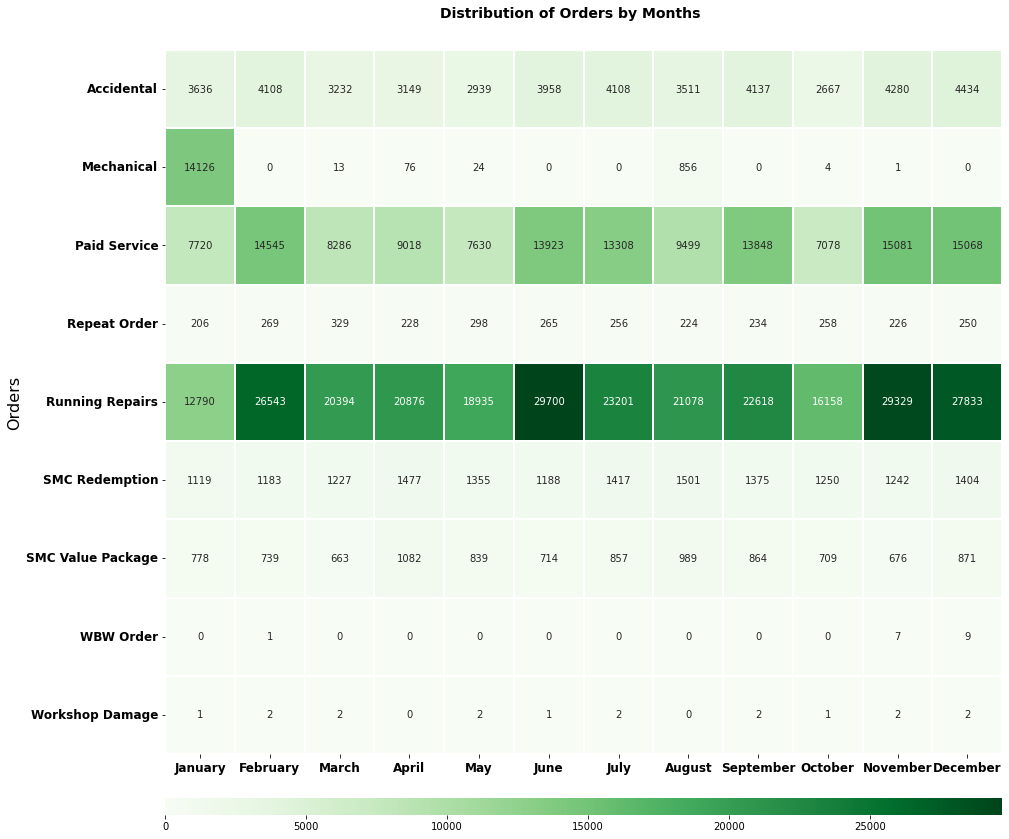

In [32]:
fig4, ax = plt.subplots(figsize=(15, 15))
fig4.subplots_adjust(top=.94)
plt.suptitle('Distribution of Orders by Months', fontsize=14, fontweight='bold')

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, weight='bold')

cbar_kws = {'orientation':"horizontal", 'pad':0.05, 'aspect':50}
sns.heatmap(order_month, annot=True, fmt='g', linewidths=.2, ax=ax, cmap='Greens', cbar_kws=cbar_kws);
ax.set_ylabel('Orders', fontsize=16)

plt.savefig('assets/orders-month-fig4.jpeg', bbox_inches='tight')

The heatmap above displays the various sorts of orders that have been received over the months. Over the years, we've seen that the majority of mechanical orders occur around January and August. Customers visiting a factory for paid service or running repairs, the two most typical forms of orders, do not follow a seasonal pattern.

Since there's no seasonal trend in the orders received, MFCS can stock up their inventory with common parts like oil and air filters for most popular car brands in order to reduce their service times.

Let's have a look at the customer arrive times over the dataset at a particular day. These arrival times are calculated based on the `JobCardDateTime` column.

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_9184/2265261460.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



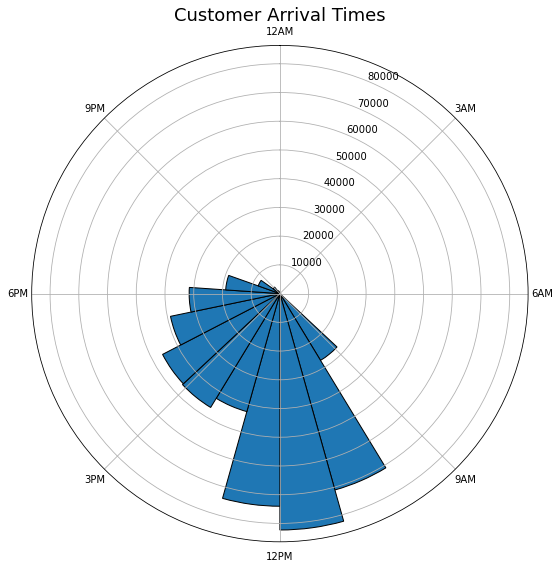

In [33]:
N = 23
bottom = 2
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii, tick = np.histogram(season.arrive_hr, bins = 23)
width = (2*np.pi) / N

plt.figure(figsize = (10, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom, edgecolor='black');

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ticks = ['12AM', '3AM', '6AM', '9AM', '12PM', '3PM', '6PM', '9PM']
ax.set_xticklabels(ticks)

plt.title("Customer Arrival Times", fontsize=18);
plt.tight_layout();

plt.savefig('assets/arrival-times-fig5.jpeg', bbox_inches='tight')

The majority of consumers arrive between 9 a.m. and 12 p.m. After 12 p.m., there is a downward tendency. This may assist MFCS in organising their labour force so that customers receive prompt help during peak hours.

## Revenue

Let's have a look at the revenue generated over the years and it's respective streams. We will also look at Parts-to-Labour ratio which is the ratio of labor sales to parts sold. The parts-to-labor ratio provides insight into how much a company's revenue is derived from services performed and how much depends on selling parts. MFCS managers can use parts-to-labor ratio to make informed decisions on how much to charge for labor and parts.

In [34]:
invoice_cleaned['year'] = invoice_cleaned['InvoiceDateTime'].dt.year
top_districts = ['Maharashtra', 'Karnataka', 'Telangana', 'Tamil Nadu', 'Uttar Pradesh', 'Rajasthan']

In [35]:
plot_bump = (
            invoice_cleaned.loc[invoice_cleaned.district.isin(top_districts), ['year', 'district', 'total_amt_wtd_tax.']]
            .groupby(['year','district'])['total_amt_wtd_tax.']
            .sum()
)
ranks = (plot_bump
         .groupby('year')
         .rank('first', ascending=False)
         .rename('rank')
         .reset_index()
)

plot_bump = pd.merge(plot_bump, ranks, on=['year', 'district'])

ordered_districts = plot_bump[plot_bump.year == 2016].sort_values(by='rank')


In [36]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.1f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

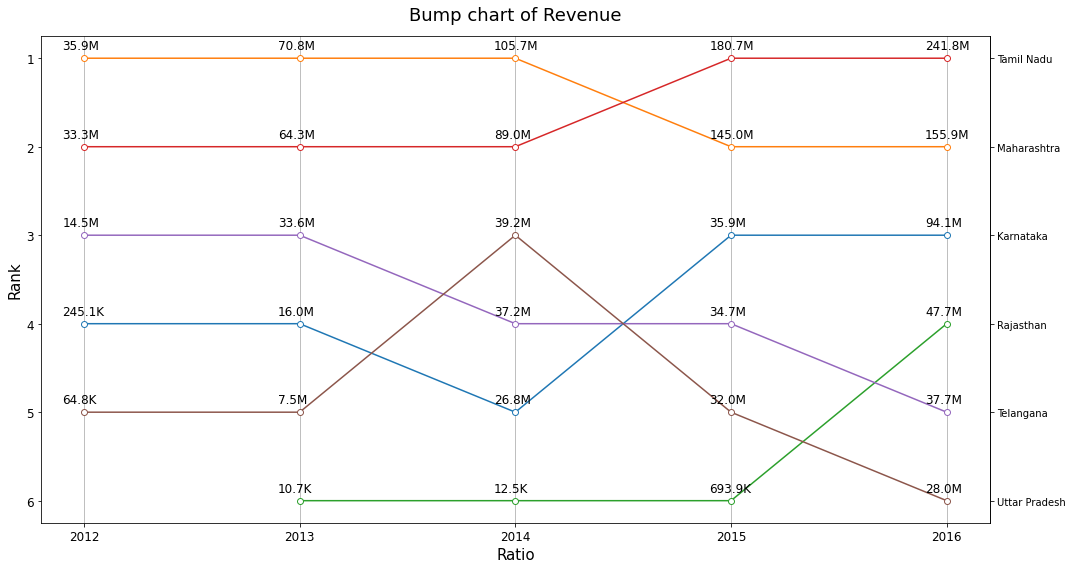

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

yax2 = ax.secondary_yaxis("right")
yax2.yaxis.set_major_locator(FixedLocator(ordered_districts['rank'].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(ordered_districts['district'].to_list()))

for i, j in plot_bump.groupby("district"):
    plt.plot('year', 'rank', "o-", data=j, mfc="w")
    for x, y, z in zip(j['year'], j['rank'], j['total_amt_wtd_tax.']):
        plt.annotate(human_format(z),xy=(x-0.1, y-0.1), fontsize=12)

ax.invert_yaxis()
ax.set_title("Bump chart of Revenue", fontsize=18, x=0.5,y=1.02);
ax.set_xlabel('Ratio', fontsize=15);
ax.set_ylabel('Rank',fontsize=15);
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(axis="x");
plt.tight_layout();

plt.savefig('assets/bump-fig6.jpeg', bbox_inches='tight')

The graph above depicts how revenue has evolved over the years. We only look at the top six states (MH, TN, KA, RJ, TL, UP) because they contribute the most to overall revenue.

Overall, even though Maharashtra lost first place to Tamil Nadu in 2015, the state's revenue continues to rise. Many rankings shift after 2014, with Uttar Pradesh, which was ranked third in 2014, falling to last place by 2016. Rajasthan's revenue increased dramatically in 2016, owing to the opening of new factories by MFCS the previous year.

Parts-to-labor ratio is equal to parts sales divided by labor sales. For example, if an auto repair shop sells \$80,000 in parts during a certain month and charges customers \$100,000 for labor performed during that month, its parts-to-labor ratio for the month is 80,000 divided by 100,000, or 0.8. This means that for every dollar of labor sales that the company makes, it sells 80 cents worth of parts.

According to Bob O'Connor of Motor Magazine, a parts-to-labor ratio in the range of 0.8 to 1 is considered normal for the auto repair industry. If the parts-to-labor ratio exceeds 1, it means parts sales account for a greater proportion of total revenue than labor sales, which indicates that a shop is charging too little for labor or too much for parts.

In [38]:
year_df = invoice_cleaned[['job_card_no', 'make', 'total_amt_wtd_tax.']].drop_duplicates(subset='job_card_no').reset_index(drop=True)

In [39]:
ptl_df = pd.merge(year_df, 
         jtd_df[['DBM Order', 'Description', 'Item Category', 'Order Quantity', 'Net value']],
         left_on='job_card_no',
         right_on='DBM Order',
         how='inner'
)

ptl_df['charges'] = np.where(ptl_df['Item Category'] == 'P002', ptl_df['Order Quantity'] * ptl_df['Net value'], ptl_df['Net value'])
charges = ptl_df[ptl_df['Item Category'].isin(['P001', 'P002'])].groupby(['make', 'Item Category'])['charges'].sum().unstack()
charges['ratio'] = charges['P002'] / charges['P001']

charges.sort_values('ratio', ascending=True, inplace=True)
charges.reset_index(inplace=True)
charges = charges.iloc[:-1]

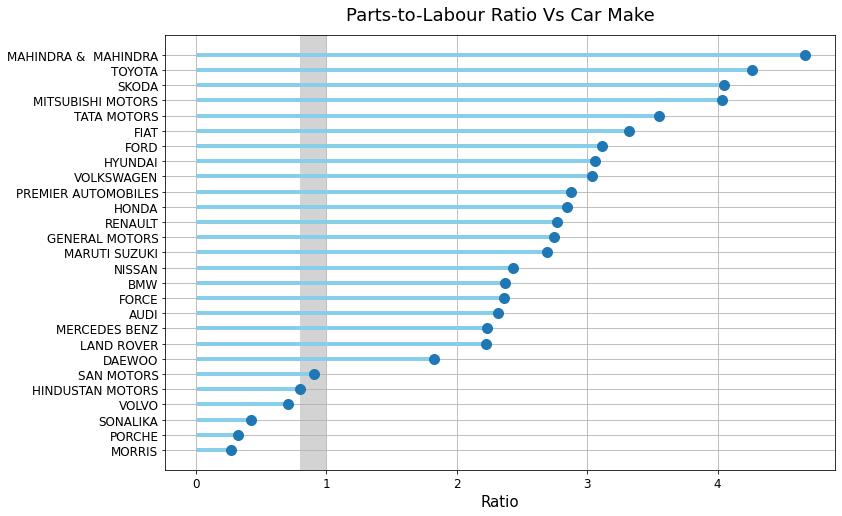

In [40]:
fig = plt.figure(figsize=(12,8));
my_range=range(1,len(charges.index)+1)
 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=charges['ratio'], color='skyblue', lw=4);
plt.plot(charges['ratio'], my_range, "o", markersize=10);
plt.axvspan(1,.8, facecolor='lightgray');

 
# Add titles and axis names
plt.yticks(my_range, charges['make']);
plt.title("Parts-to-Labour Ratio Vs Car Make", fontsize=18, x=0.5,y=1.02);
plt.xlabel('Ratio', fontsize=15);
plt.ylabel('',fontsize=15);
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);
plt.grid();

plt.savefig('assets/ratio-make-fig7.jpeg', bbox_inches='tight');

We can see from the diagram above that MFCS is charging too much for parts and too little for labour on majority of the automobiles. Given that our dataset consists primarily of labor-intensive running repairs and paid services, and that the majority of the automobiles are from the economical group (Maruti Suzuki, Mahindra & Mahindra, and so on), MFCS can strive to balance this ratio in order to maximise their profit margins.

Finally let's have a look at different sources of customers

In [41]:
cust_origin = field_info.iloc[:23, 3:5]

cust_origin.columns = list(cust_origin.iloc[0])
cust_origin = cust_origin.iloc[1:].reset_index(drop=True)
cust_origin.loc[4, 'Origin'] = 'Z005'

In [42]:
cust_origin_dict = dict(zip(cust_origin.Origin, cust_origin.Description))
cust_df.insert(4, 'Origin Text',cust_df['Data Origin'].map(cust_origin_dict))
cust_df.head(3)

,Business Partner,Customer No.,Partner Type,Data Origin,Origin Text,Title,Marital Status,Occupation,Date of Birth,Death date
0,31,1,1.0,Z001,Camp - Outdoor,NaN,NaN,NaN,NaN,NaT
1,32,2,1.0,Z005,Ref - Customer,NaN,NaN,NaN,NaN,NaT
2,34,4,1.0,Z005,Ref - Customer,NaN,2.0,NaN,NaN,NaT


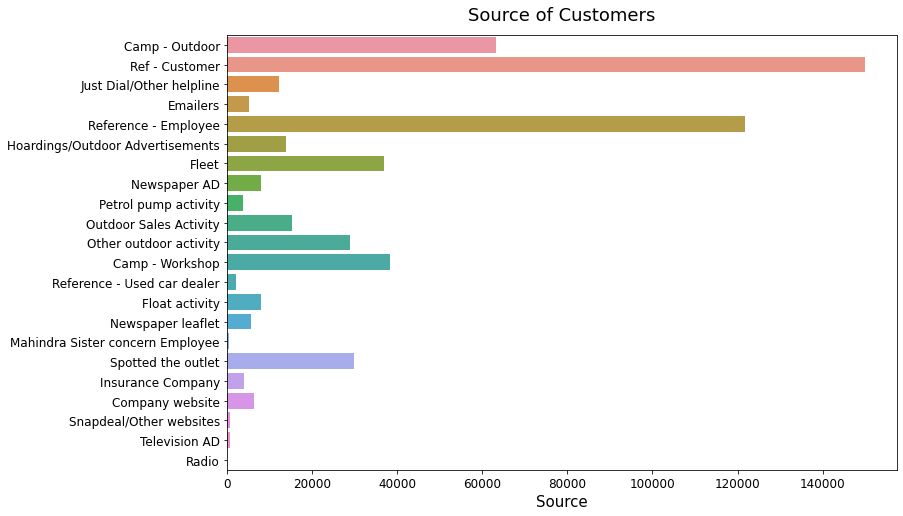

In [43]:
plt.figure(figsize=(12,8))
sns.countplot(y=cust_df['Origin Text'])
plt.title("Source of Customers", fontsize=18, x=0.5,y=1.02);
plt.xlabel('Source', fontsize=15);
plt.ylabel('')
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);

plt.savefig('assets/origin-customer-fig8.jpeg', bbox_inches='tight')

The origin of MFCS's client population can be seen in this graph. As can be observed, referrals account for about half of the total clients. The remaining 50% of clients come via marketing techniques such as hosting camps/workshops or placing ads in newspapers, television, and other media.

Knowing this, MFCS can improve its profit margins by enhancing its referral policies, lowering advertising expenditures in the process.